<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' Sentiment Analysis 

### Imports and loading data

In [570]:
import pandas as pd
import numpy as np
import itertools
import collections
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import warnings
sns.set_theme()
sns.diverging_palette(220, 20, as_cmap=True)

warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment', None)

In [571]:
# # Setting up stopwords list
stopwords = set(STOPWORDS)
# excluding keywords used in query (collection words)
stopwords.update(['covid', 'covid19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccinated', 'lockdown', 'quarantine'])
# excluding a couple more irrelevant ones
stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're', 'amp'])

In [572]:
df = pd.read_pickle('../data/covid19_tweets_cleaned_5000.pkl')
# df = pd.read_csv('../data/covid19_tweets_cleaned.csv', converters={'column_name': eval})

In [573]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   text          5000 non-null   object
 2   datetime      5000 non-null   object
 3   no_replies    5000 non-null   int64 
 4   no_retweets   5000 non-null   int64 
 5   no_likes      5000 non-null   int64 
 6   user          5000 non-null   object
 7   location      3767 non-null   object
 8   no_followers  5000 non-null   int64 
 9   sentiment     5000 non-null   object
 10  text_clean    5000 non-null   object
 11  text_stem     5000 non-null   object
 12  text_lem      5000 non-null   object
dtypes: int64(5), object(8)
memory usage: 507.9+ KB


In [574]:
df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment                                         text_clean  \
0            43  negative  still exists and yall are so so close to mark ...   
1           935   neutral  school districts plan for the most unfeasable ...   
2          1828   neutral  omnibus  emergency measures  bill  introduced ...   
3         14712  positive  from the archives  coming together when we’re ...   
4          1231  positive  yo korean government has succeeded in developi...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...

In [575]:
# Original text
df['text'][22]

'The U.S. #airline industry and its pilots are essential to the distribution of a COVID-19 vaccine. Congress and government leaders must #ExtendPSP now to ensure critical infrastructure is in place to distribute a vaccine—American lives depend on it @SenRickScott.'

In [576]:
# Pre-processed text - stemmed
df['text_stem'][22]

['airlin',
 'industri',
 'pilot',
 'essenti',
 'distribut',
 'congress',
 'govern',
 'leader',
 'must',
 'extendpsp',
 'now',
 'ensur',
 'critic',
 'infrastructur',
 'place',
 'distribut',
 'american',
 'live',
 'depend',
 'senrickscott']

In [577]:
# Pre-processed text - lemmatized
df['text_lem'][22]

['airline',
 'industry',
 'pilot',
 'essential',
 'distribution',
 'congress',
 'government',
 'leader',
 'must',
 'extendpsp',
 'now',
 'ensure',
 'critical',
 'infrastructure',
 'place',
 'distribute',
 'american',
 'life',
 'depend',
 'senrickscott']

### Lexicon-based EDA 

#### Import lexicons  
A lexicon is a dictionary of words that computes the sentiment of a words by analyzing the "semantic orientation" of that word in a text. These codings are made by people, through crowdsorcing, etc.

- **Afinn**: gives the words a number between -5, 5, where -5 means that the words is very negative and 5 means that the words is very positive  
- **Bing**: gives the words an assignment of positive/negative sentiment  
- **NRC**: assigns the words one of the 8 primary emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and 2 sentiments (positive and negative)

In [578]:
afinn = pd.read_csv('../data/lexicons/Afinn.csv')
bing = pd.read_csv('../data/lexicons/Bing.csv')
nrc = pd.read_csv('../data/lexicons/NRC.csv')

In [579]:
print(len(afinn))
print(len(bing))
print(len(nrc))

2477
6786
13901


In [580]:
afinn.head()

word  value
0    abandon     -2
1  abandoned     -2
2   abandons     -2
3   abducted     -2
4  abduction     -2

In [581]:
bing.head()

word sentiment
0     2-faces  negative
1    abnormal  negative
2     abolish  negative
3  abominable  negative
4  abominably  negative

In [582]:
# filtering out potsitive/negative sentiments from NRC 
nrc = nrc[(nrc['sentiment'] != 'positive') & (nrc['sentiment'] != 'negative')]
nrc.columns = ['word', 'emotion']
nrc.head()

word  emotion
0     abacus    trust
1    abandon     fear
3    abandon  sadness
4  abandoned    anger
5  abandoned     fear

#### Positive-Negative Wordcloud (redone with lemmatized tweets)

In [583]:
all_words = [item for sublist in df['text_lem'] for item in sublist]
counts = collections.Counter(all_words)
top_counts = pd.DataFrame(counts.most_common(16), columns=['word', 'count'])

Text(0.5, 1.0, '15 most frequent words')

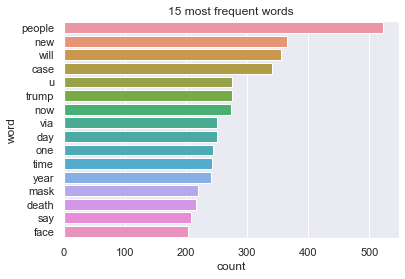

In [584]:
sns.barplot(x=top_counts['count'], y=top_counts['word']).set_title('15 most frequent words')

In [585]:
# join with sentiments from lexicons 
count_df = pd.DataFrame({'word': counts.keys(), 'count': counts.values()})
count_df = count_df.merge(afinn, how='left', on='word')
count_df = count_df.merge(bing, how='left', on='word')
count_df = count_df.merge(nrc, how='left', on='word')
count_df.head(10)

word  count  value sentiment       emotion
0     still    151    NaN       NaN           NaN
1    exists      3    NaN       NaN           NaN
2      yall     13    NaN       NaN           NaN
3     close     38    NaN       NaN           NaN
4      mark     13    NaN       NaN           NaN
5   triumph     10    4.0  positive  anticipation
6   triumph     10    4.0  positive           joy
7    school    120    NaN       NaN         trust
8  district     12    NaN       NaN           NaN
9      plan     73    NaN       NaN  anticipation

In [586]:
pos_words = count_df[count_df['sentiment'] == 'positive']['word'].drop_duplicates().tolist()
neg_words = count_df[count_df['sentiment'] == 'negative']['word'].drop_duplicates().tolist()

In [587]:
def filter_sentiment(text, words_to_filter): # veeery slow way
    return [word for word in text if any(n in word for n in words_to_filter)]

# def filter_sentiment(text, words_to_filter):
#     text_s = "".join([word for word in text if word in words_to_filter]) 
#     return text_s

pos_df = df['text_stem'].apply(lambda x: filter_sentiment(x, pos_words))
neg_df = df['text_stem'].apply(lambda x: filter_sentiment(x, neg_words))

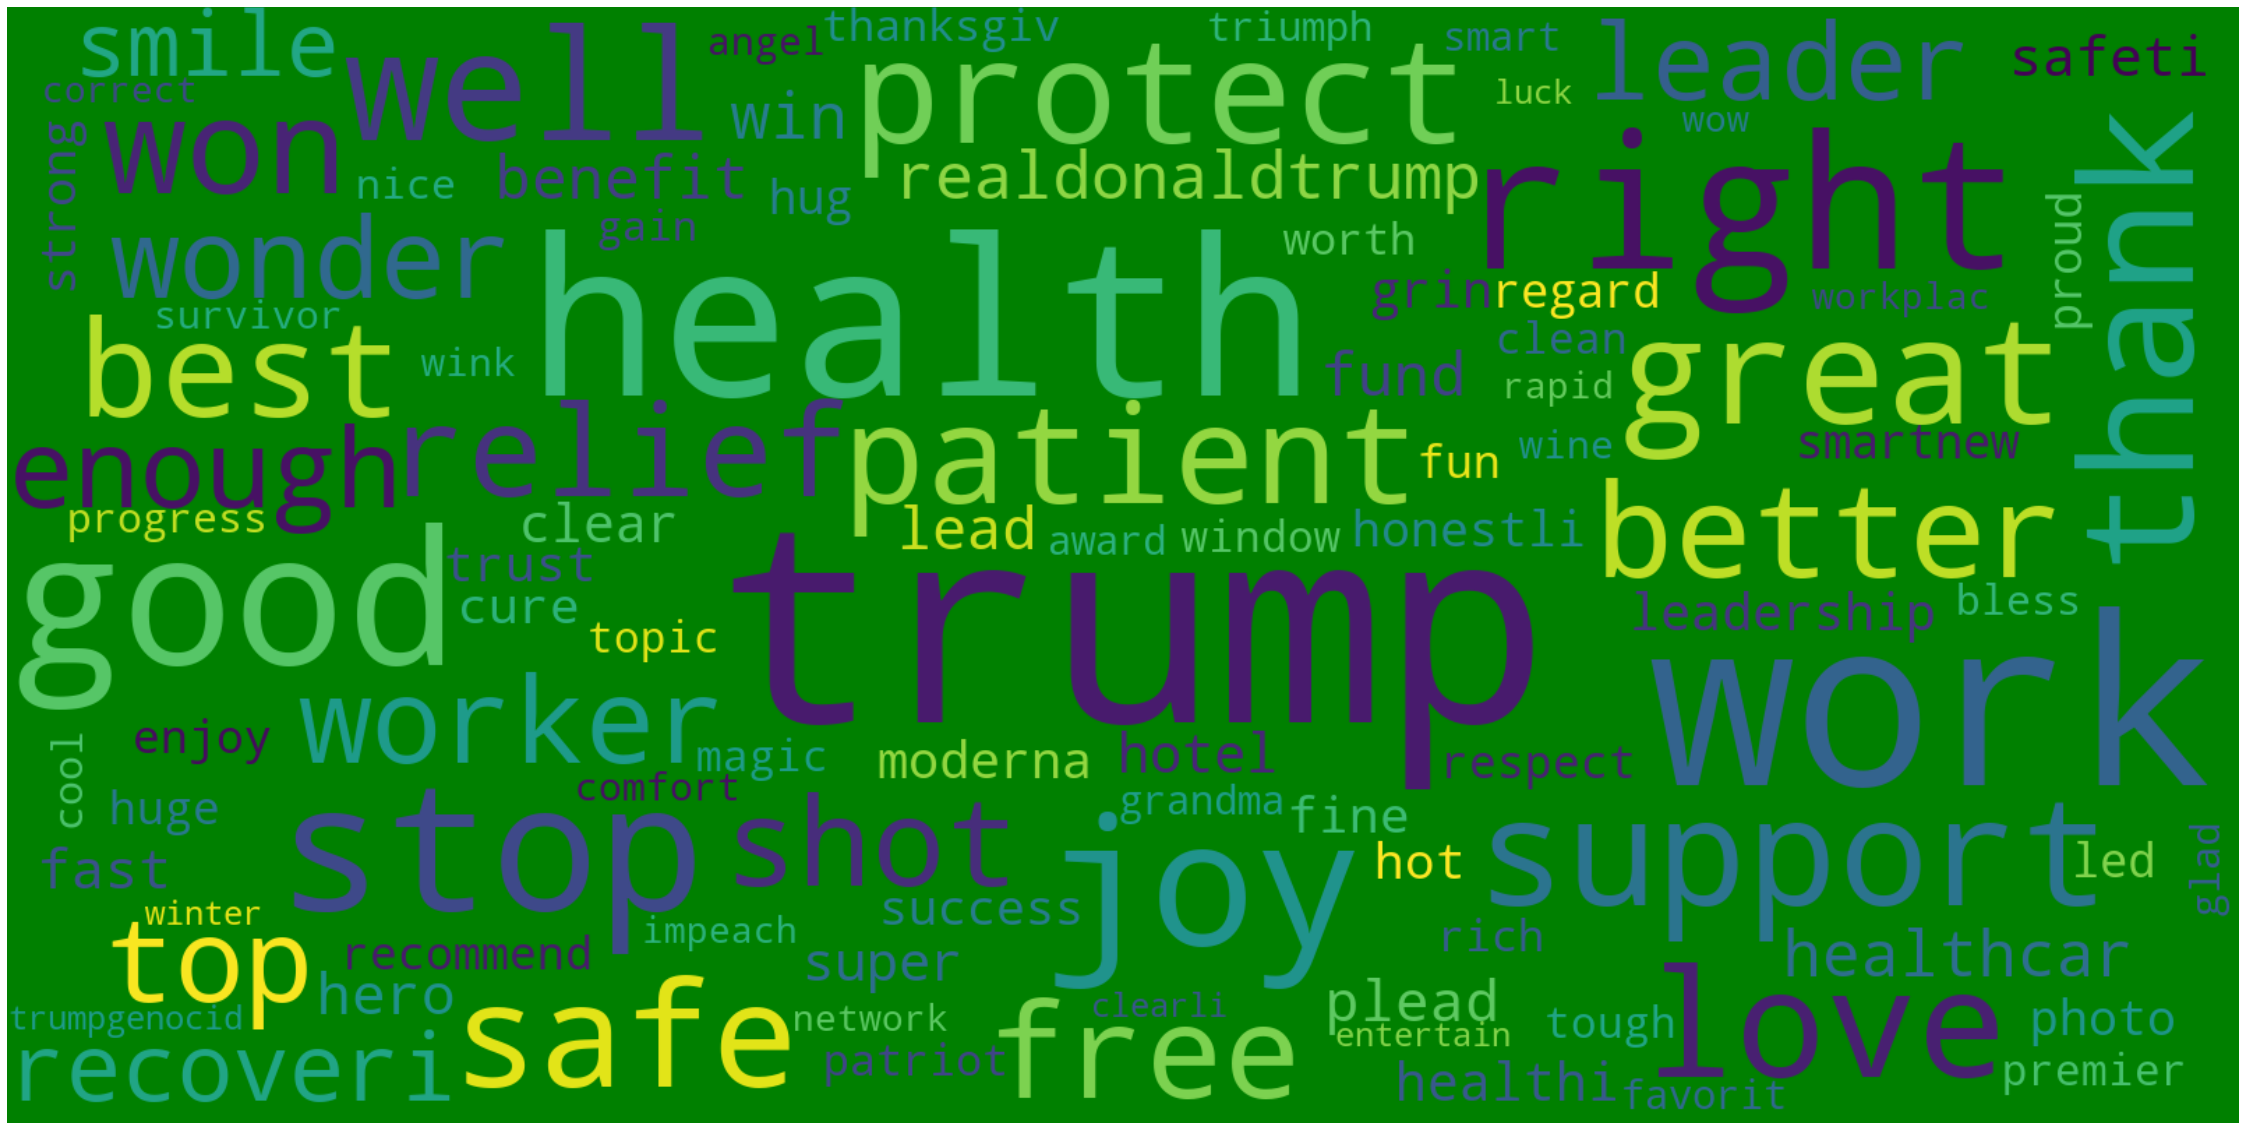

In [588]:
# Positive
string_pos = pos_df.apply(lambda x: " ".join(x))
string_pos = pd.Series(string_pos).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='green').generate_from_text(string_pos)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

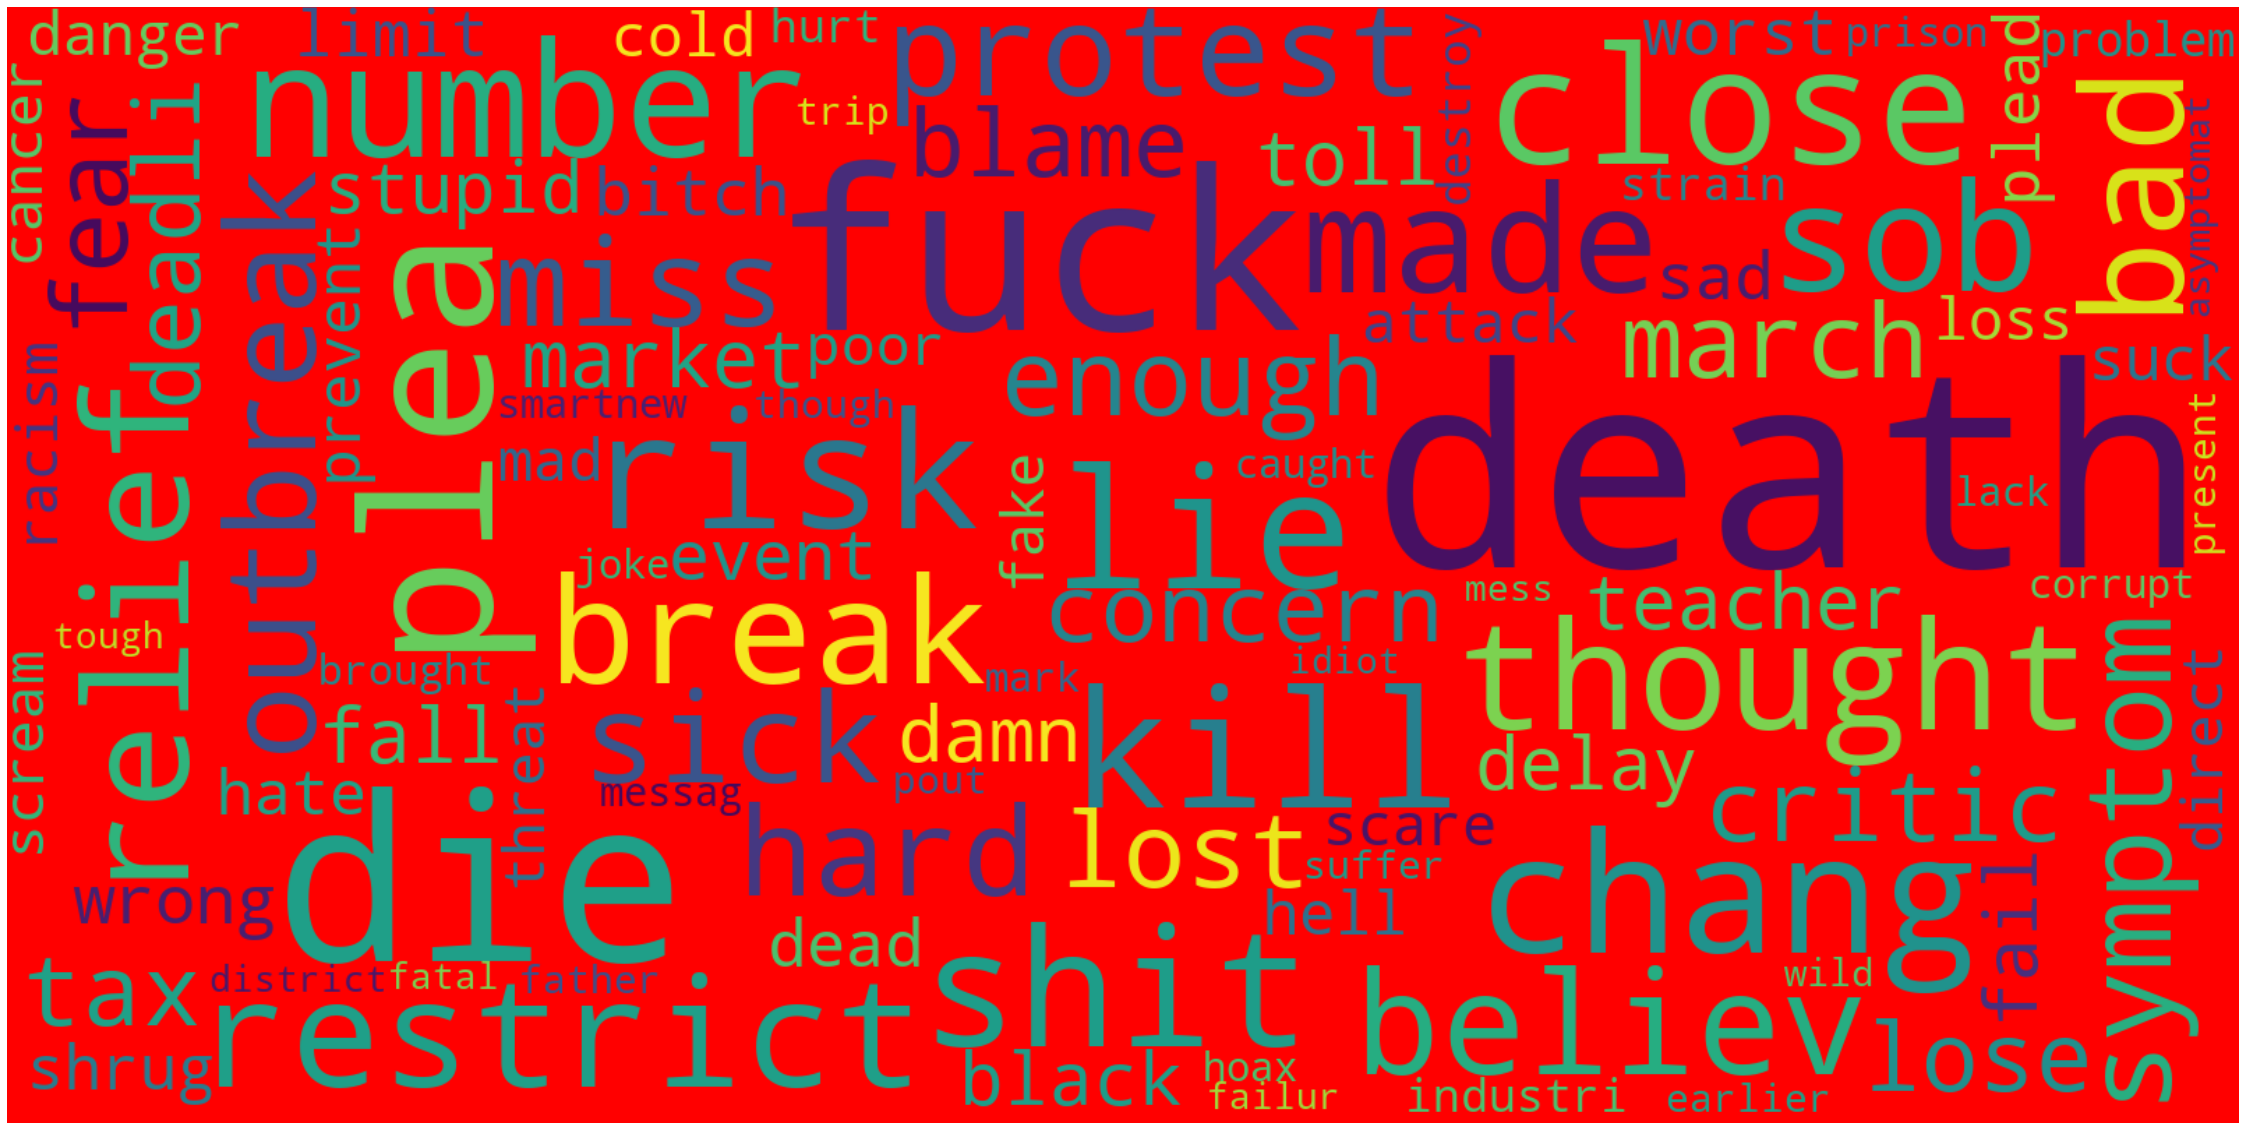

In [589]:
# Negative
string_neg = neg_df.apply(lambda x: " ".join(x))
string_neg = pd.Series(string_neg).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='red').generate_from_text(string_neg)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Primary Emotions Analysis

In [631]:
# emotions taken from NRC lexicon - for multiple matches take first (temporary solution)
sentiment_df = count_df[['count', 'emotion']].dropna()
sentiment_df = sentiment_df.groupby('emotion').first().reset_index()
sentiment_df = sentiment_df.sort_values('count', ascending=False)
sentiment_df = sentiment_df.rename(columns={'emotion': 'emocja'})
sentiment_df["emocja"].replace({"fear": "strach", "surprise": "zaskoczenie", "anticipation": "oczekiwanie", "anger": "gniew",\
    "trust": "zaufanie", "joy": "radość", "sadness": "smutek", "disgust": "odraza"}, inplace=True)

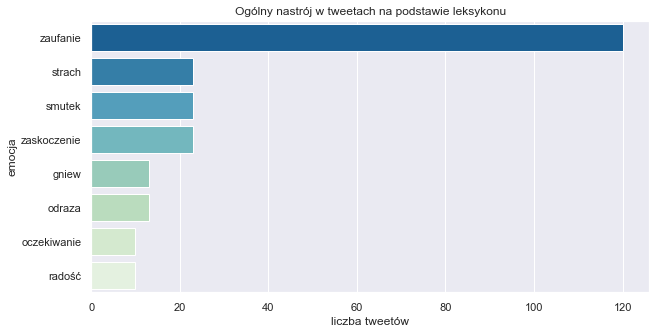

In [632]:
plt.figure(figsize=(10,5))
fig = sns.barplot(x=sentiment_df['count'], y=sentiment_df['emocja'], palette='GnBu_r')
fig.set(xlabel='liczba tweetów', ylabel='emocja', title='Ogólny nastrój w tweetach na podstawie leksykonu')
plt.show()

#### Emotions Split by Words

In [592]:
emotions_df = count_df[['word', 'count', 'emotion']].dropna()
emotions_df = emotions_df.groupby(['word', 'count']).first().reset_index()
emotions_df = emotions_df.sort_values('count', ascending=False)
emotions_df = emotions_df.groupby('emotion').head(10).reset_index(drop=True)

In [593]:
emotions_df = emotions_df.rename(columns={'emotion': 'emocja'})
emotions_df["emocja"].replace({"fear": "strach", "surprise": "zaskoczenie", "anticipation": "oczekiwanie", "anger": "gniew",\
    "trust": "zaufanie", "joy": "radość", "sadness": "smutek", "disgust": "odraza"}, inplace=True)

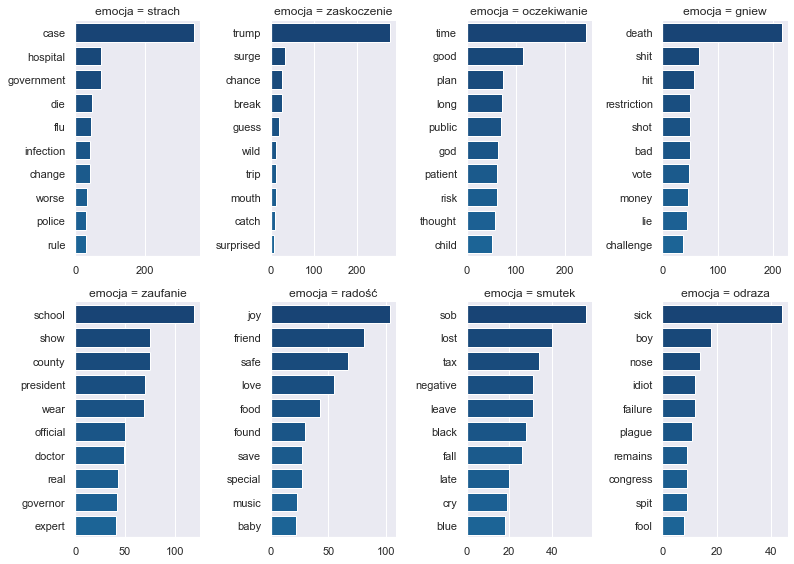

In [594]:
fig = sns.catplot(x="count", y="word", col="emocja",
            data=emotions_df, kind="bar",
            height=4, aspect=.7, col_wrap=4, 
            sharex=False, sharey=False, palette='GnBu_r')

fig.set(xlabel='', ylabel='')
plt.show()

#### Sentiment Split by Words

In [595]:
sentiment_df = count_df[['word', 'count', 'sentiment']].dropna()
sentiment_df = sentiment_df.groupby(['word', 'count']).first().reset_index()
sentiment_df = sentiment_df.sort_values('count', ascending=False)
sentiment_df = sentiment_df.groupby('sentiment').head(10).reset_index(drop=True)

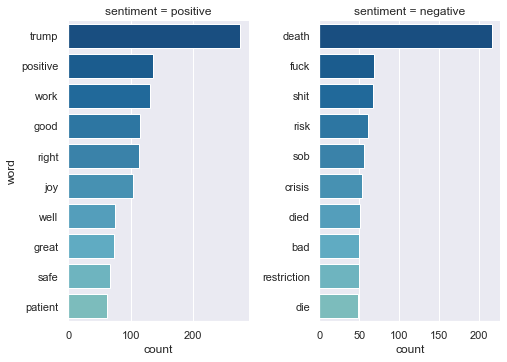

In [596]:
s = sns.catplot(x="count", y="word", col="sentiment",
            data=sentiment_df, kind="bar",
            height=5, aspect=.7, col_wrap=4, 
            sharex=False, sharey=False, color=None, palette='GnBu_r')

#### Sentiment Distribution

In [597]:
value_df = count_df[['word', 'count', 'value']].drop_duplicates().dropna()
value_df = value_df.sort_values('count', ascending=False)#.reset_index(drop=True)
value_df = value_df.groupby('value').sum('count').reset_index()

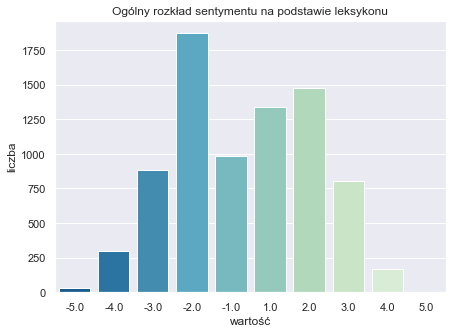

In [598]:
plt.figure(figsize=(7,5))
fig = sns.barplot(x=value_df['value'], y=value_df['count'], palette='GnBu_r')
fig.set(xlabel='wartość', ylabel='liczba', title='Ogólny rozkład sentymentu na podstawie leksykonu')
plt.show()

In [599]:
df_sent_actual

sentiment    id
0  negatywny  1808
1  neutralny  1666
2  pozytywny  1526

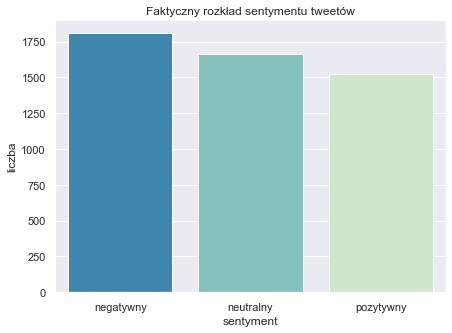

In [600]:
plt.figure(figsize=(7,5))
df_sent_actual = df[['sentiment', 'id']].groupby('sentiment').count().reset_index()
df_sent_actual["sentiment"].replace({"negative": "negatywny", "neutral": "neutralny", "positive": "pozytywny"}, inplace=True)
fig = sns.barplot(x=df_sent_actual['sentiment'], y=df_sent_actual['id'], palette='GnBu_r')
fig.set(xlabel='sentyment', ylabel='liczba', title='Faktyczny rozkład sentymentu tweetów')
plt.show()

In [694]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.strftime('%Y-%m')
df_sent_time = df[['sentiment', 'date', 'id']].groupby(['sentiment', 'date']).count().reset_index()
df_sent_time["sentiment"].replace({"negative": "negatywny", "neutral": "neutralny", "positive": "pozytywny"}, inplace=True)
df_sent_time = df_sent_time.rename(columns={'sentiment': 'sentyment', 'date': 'data', 'id':'liczba'})
df_sent_time = df_sent_time.pivot(index='data', columns='sentyment')['liczba'].reset_index()

In [696]:
df_sent_time_p = pd.DataFrame()
df_sent_time_p['data'] = df_sent_time['data']
df_sent_time_p['negatywny'] = df_sent_time['negatywny']/(df_sent_time['negatywny'] + df_sent_time['neutralny'] + df_sent_time['pozytywny']) * 100
df_sent_time_p['neutralny'] = df_sent_time['neutralny']/(df_sent_time['negatywny'] + df_sent_time['neutralny'] + df_sent_time['pozytywny']) * 100
df_sent_time_p['pozytywny'] = df_sent_time['pozytywny']/(df_sent_time['negatywny'] + df_sent_time['neutralny'] + df_sent_time['pozytywny']) * 100

df_sent_time_p = pd.melt(df_sent_time_p, id_vars=['data'], value_vars=['negatywny', 'neutralny', 'pozytywny'], var_name='sentyment', value_name='procent')
df_sent_time_p = df_sent_time_p.pivot(index='sentyment', columns='data')['procent'].reset_index()
df_sent_time_p#.set_index('sentyment').T

data  sentyment    2020-03    2020-04    2020-05    2020-06    2020-07  \
0     negatywny  36.901408  30.882353  36.197917  40.384615  43.188406   
1     neutralny  37.464789  33.235294  34.895833  34.615385  26.666667   
2     pozytywny  25.633803  35.882353  28.906250  25.000000  30.144928   

data    2020-08    2020-09    2020-10    2020-11    2020-12    2021-01  \
0     37.359551  37.830688  40.229885  39.595376  35.608309  32.791328   
1     32.584270  33.333333  30.747126  32.080925  31.750742  31.436314   
2     30.056180  28.835979  29.022989  28.323699  32.640950  35.772358   

data    2021-02    2021-03    2021-04  
0     36.619718  28.301887  30.681818  
1     35.774648  35.579515  35.795455  
2     27.605634  36.118598  33.522727

In [692]:
df_sent_time

data  sentyment  2020-03  2020-04  2020-05  2020-06  2020-07  2020-08  \
0     negatywny      131      105      139      147      149      133   
1     neutralny      133      113      134      126       92      116   
2     pozytywny       91      122      111       91      104      107   

data  2020-09  2020-10  2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  
0         143      140      137      120      121      130      105      108  
1         126      107      111      107      116      127      132      126  
2         109      101       98      110      132       98      134      118

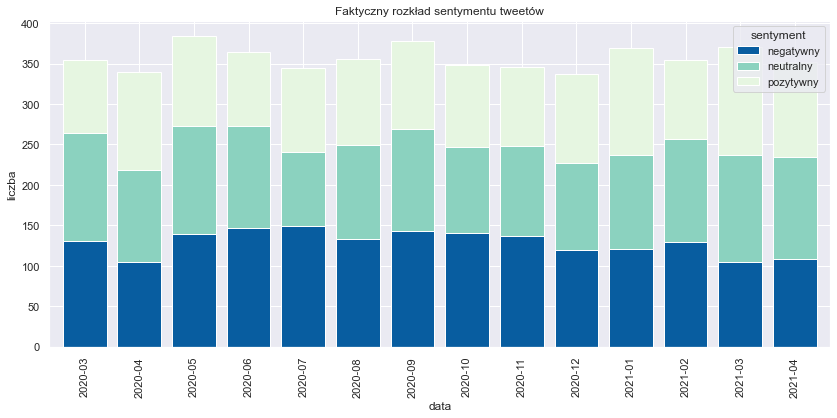

In [693]:
from matplotlib.colors import ListedColormap

fig = df_sent_time.set_index('sentyment').T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu_r", 10)), 
          figsize=(14,6), mark_right=True, width = 0.8)
fig.set(xlabel='data', ylabel='liczba', title='Faktyczny rozkład sentymentu tweetów')
plt.show()

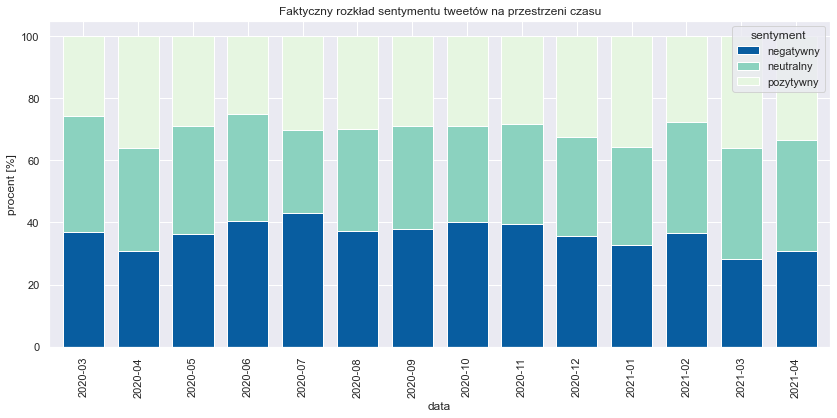

In [701]:
from matplotlib.colors import ListedColormap

fig = df_sent_time_p.set_index('sentyment').T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu_r", 10)), 
          figsize=(14,6), mark_right=True, width = 0.75)
fig.set(xlabel='data', ylabel='procent [%]', title='Faktyczny rozkład sentymentu tweetów na przestrzeni czasu')
plt.show()

### Dataset preparation

In [ ]:
df['text_lem'] = df['text_lem'].apply(lambda x: " ".join(x))
df['text_stem'] = df['text_stem'].apply(lambda x: " ".join(x))
df

In [604]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['sentiment'])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [772]:
# train test split for rule based - textblob
X_text = df['text_lem'].values  
y = le.transform(df['sentiment'].values)
y

array([0, 1, 1, ..., 0, 1, 1])

In [773]:
from sklearn.model_selection import train_test_split  
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

### Rule-based algorithms

Topic-specific phrases and words adjustmens
- positive
- negative
- trump
- tf
- gtfo
- hoe

#### TextBlob

In [774]:
from textblob import TextBlob

def textblob_compound(text, threshold=0.05):
    blob = TextBlob(text)
    score = blob.sentiment.polarity
    
    if score <= -threshold: return 0
    elif score >= threshold: return 2
    else: return 1

In [734]:
y_pred_textblob = pd.DataFrame(X_test_text)[0].apply(lambda x: textblob_compound(x))
y_pred_textblob.head()

0    1
1    2
2    2
3    0
4    2
Name: 0, dtype: int64

#### VADER

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).  

positive sentiment : (compound score >= 0.05)   
neutral sentiment : (compound score > -0.05) and (compound score < 0.05)   
negative sentiment : (compound score <= -0.05)  

In [735]:
def vader_compound(text, threshold=0.05):
    # Calling the polarity_scores method on sid and passing in the text
    # outputs a dictionary with negative, neutral, positive, and compound scores for the input text
    scores = SIA.polarity_scores(text)

    # get compound score
    score = scores['compound']
     
    # translate the score into the correcponding input according to the threshold
    if score <= -threshold: return 0
    elif score >= threshold: return 2
    else: return 1
    # f score <= -threshold: return 'negative'
    # elif score >= threshold: return 'positive'
    # else: return 'neutral'

    #return sid.polarity_scores(text)['compound']


In [775]:
# train test split for rule based - VADER
X_text = df['text_clean'].values  
y = le.transform(df['sentiment'].values)
y

array([0, 1, 1, ..., 0, 1, 1])

In [776]:
from sklearn.model_selection import train_test_split  
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

In [777]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'positive': 0.0,
    'negative': 0.0,
    'trump': 0.0,
    'gtfo': -4.0,
    'taking away': -2.0,
    'aggy': -2.0,
    'hoe': -4.0,
    'increase': -1.0,
    'bs': -2.0,
    'wtfck': -4.0,
    'supremacy': -2.0,
    'nazi': -2.0,
    'nationalist': -2.0,
    'fucking': -4.0,
    'lied': -4.0,
    'discrimination': -4.0,
    'break down': -4.0,
    'wtfits': -4.0,
    'wtf': -4.0,
    'stfu': -4.0,
    'mockery': -4.0,
    'hoax': -4.0 

    
}
SIA = SentimentIntensityAnalyzer()

SIA.lexicon.update(new_words)

y_pred_vader = pd.DataFrame(X_test_text)[0].apply(lambda x: vader_compound(x))
y_pred_vader.head()

0    1
1    2
2    0
3    0
4    1
Name: 0, dtype: int64

In [780]:
# setting up the resulting data frame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

df_results = pd.DataFrame({'algorytm': ['TextBlob','VADER','RL', 'RL', 'SVC', 'SVC', 'NB', 'NB'], 'waktoryzacja': ['-', '-', 'BoW', 'TF-IDF', 'BoW', 'TF-IDF', 'BoW', 'TF-IDF']})
df_results['accuracy'] = [accuracy_score(y_test, y_pred_textblob), accuracy_score(y_test, y_pred_vader), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_lr_tfidf), \
    accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_svc_tfidf), accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_nb_tfidf)]

df_results['precision'] = [precision_score(y_test, y_pred_textblob, average='weighted'), precision_score(y_test, y_pred_vader, average='weighted'), precision_score(y_test, y_pred_lr, average='weighted'), \
    precision_score(y_test, y_pred_lr_tfidf, average='weighted'), precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    precision_score(y_test, y_pred_nb, average='weighted'), precision_score(y_test, y_pred_nb_tfidf, average='weighted')]

df_results['recall'] = [recall_score(y_test, y_pred_textblob, average='weighted'), recall_score(y_test, y_pred_vader, average='weighted'), recall_score(y_test, y_pred_lr, average='weighted'), \
    recall_score(y_test, y_pred_lr_tfidf, average='weighted'), recall_score(y_test, y_pred_svc, average='weighted'), recall_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    recall_score(y_test, y_pred_nb, average='weighted'), recall_score(y_test, y_pred_nb_tfidf, average='weighted')]

df_results['f1_score'] = [f1_score(y_test, y_pred_textblob, average='weighted'), f1_score(y_test, y_pred_vader, average='weighted'), f1_score(y_test, y_pred_lr, average='weighted'), \
    f1_score(y_test, y_pred_lr_tfidf, average='weighted'), f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    f1_score(y_test, y_pred_nb, average='weighted'), f1_score(y_test, y_pred_nb_tfidf, average='weighted')]

df_results

algorytm waktoryzacja  accuracy  precision  recall  f1_score
0  TextBlob            -     0.481   0.520866   0.481  0.476144
1     VADER            -     0.803   0.810772   0.803  0.800596
2        RL          BoW     0.588   0.600218   0.588  0.587387
3        RL       TF-IDF     0.601   0.602945   0.601  0.601073
4       SVC          BoW     0.575   0.582811   0.575  0.574296
5       SVC       TF-IDF     0.589   0.590829   0.589  0.589400
6        NB          BoW     0.548   0.546805   0.548  0.540205
7        NB       TF-IDF     0.546   0.556824   0.546  0.533504

### Vectorization

In [814]:
# train test split for ml based
X_text_lem = df['text_stem'].values  
X_train_text_lem, X_test_text_lem, y_train, y_test = train_test_split(X_text_lem, y, test_size=0.2, random_state=42, stratify=y)

#### Bag of Words

In [815]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(pd.DataFrame(X_train_text_lem)[0])
X_test_bow = vectorizer.transform(pd.DataFrame(X_test_text_lem)[0])

In [816]:
X_train_bow.shape

(4000, 9057)

#### TF-IDF

In [817]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf = True,
                             use_idf = True)
X_train_tfidf = vectorizer.fit_transform(pd.DataFrame(X_train_text_lem)[0])
X_test_tfidf = vectorizer.transform(pd.DataFrame(X_test_text_lem)[0])

In [818]:
X_train_tfidf.shape

(4000, 9057)

### Machine Learning algorithms

#### BoW

In [819]:
# LR
from sklearn.linear_model import LogisticRegression
lr_bow = LogisticRegression(random_state=42)  
lr_bow.fit(X_train_bow, y_train)
y_pred_lr = lr_bow.predict(X_test_bow)

# NB
from sklearn.naive_bayes import MultinomialNB
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_nb = nb_bow.predict(X_test_bow)

# SVC
from sklearn.svm import SVC
svc_bow = SVC(kernel='linear')
svc_bow.fit(X_train_bow, y_train)
y_pred_svc = svc_bow.predict(X_test_bow)

#### TF-IDF

In [820]:
lr_tfidf = LogisticRegression(random_state=42)  
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

svc_tfidf = SVC(kernel='linear')
svc_tfidf.fit(X_train_tfidf, y_train)
y_pred_svc_tfidf = svc_tfidf.predict(X_test_tfidf)

### Evaluation of the results

In [821]:
# setting up the resulting data frame
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

df_results = pd.DataFrame({'algorytm': ['TextBlob','VADER','RL', 'RL', 'SVC', 'SVC', 'NB', 'NB'], 'waktoryzacja': ['-', '-', 'BoW', 'TF-IDF', 'BoW', 'TF-IDF', 'BoW', 'TF-IDF']})
df_results['accuracy'] = [accuracy_score(y_test, y_pred_textblob), accuracy_score(y_test, y_pred_vader), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_lr_tfidf), \
    accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_svc_tfidf), accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_nb_tfidf)]

df_results['precision'] = [precision_score(y_test, y_pred_textblob, average='weighted'), precision_score(y_test, y_pred_vader, average='weighted'), precision_score(y_test, y_pred_lr, average='weighted'), \
    precision_score(y_test, y_pred_lr_tfidf, average='weighted'), precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    precision_score(y_test, y_pred_nb, average='weighted'), precision_score(y_test, y_pred_nb_tfidf, average='weighted')]

df_results['recall'] = [recall_score(y_test, y_pred_textblob, average='weighted'), recall_score(y_test, y_pred_vader, average='weighted'), recall_score(y_test, y_pred_lr, average='weighted'), \
    recall_score(y_test, y_pred_lr_tfidf, average='weighted'), recall_score(y_test, y_pred_svc, average='weighted'), recall_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    recall_score(y_test, y_pred_nb, average='weighted'), recall_score(y_test, y_pred_nb_tfidf, average='weighted')]

df_results['f1_score'] = [f1_score(y_test, y_pred_textblob, average='weighted'), f1_score(y_test, y_pred_vader, average='weighted'), f1_score(y_test, y_pred_lr, average='weighted'), \
    f1_score(y_test, y_pred_lr_tfidf, average='weighted'), f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_svc_tfidf, average='weighted'), \
    f1_score(y_test, y_pred_nb, average='weighted'), f1_score(y_test, y_pred_nb_tfidf, average='weighted')]

# df_results['auc_ovo'] = [roc_auc_score(y_test, y_pred_textblob, average='weighted', multi_class='ovo'), roc_auc_score(y_test, y_pred_vader, average='weighted', multi_class='ovo'), roc_auc_score(y_test, y_pred_lr, average='weighted', multi_class='ovo'), \
#     roc_auc_score(y_test, y_pred_lr_tfidf, average='weighted', multi_class='ovo'), roc_auc_score(y_test, y_pred_svc, average='weighted', multi_class='ovo'), roc_auc_score(y_test, y_pred_svc_tfidf, average='weighted', multi_class='ovo'), \
#     roc_auc_score(y_test, y_pred_nb, average='weighted', multi_class='ovo'), roc_auc_score(y_test, y_pred_nb_tfidf, average='weighted', multi_class='ovo')]

# df_results['auc_ovr'] = [roc_auc_score(y_test, y_pred_textblob, average='weighted', multi_class='ovr'), roc_auc_score(y_test, y_pred_vader, average='weighted', multi_class='ovr'), roc_auc_score(y_test, y_pred_lr, average='weighted', multi_class='ovr'), \
#     roc_auc_score(y_test, y_pred_lr_tfidf, average='weighted', multi_class='ovr'), roc_auc_score(y_test, y_pred_svc, average='weighted', multi_class='ovr'), roc_auc_score(y_test, y_pred_svc_tfidf, average='weighted', multi_class='ovr'), \
#     roc_auc_score(y_test, y_pred_nb, average='weighted', multi_class='ovr'), roc_auc_score(y_test, y_pred_nb_tfidf, average='weighted', multi_class='ovr')]

df_results.round(3)

algorytm waktoryzacja  accuracy  precision  recall  f1_score
0  TextBlob            -     0.481      0.521   0.481     0.476
1     VADER            -     0.803      0.811   0.803     0.801
2        RL          BoW     0.588      0.600   0.588     0.587
3        RL       TF-IDF     0.601      0.603   0.601     0.601
4       SVC          BoW     0.575      0.583   0.575     0.574
5       SVC       TF-IDF     0.589      0.591   0.589     0.589
6        NB          BoW     0.548      0.547   0.548     0.540
7        NB       TF-IDF     0.546      0.557   0.546     0.534

In [620]:
np.set_printoptions(precision=2)
target_names = ['negatywne', 'neutralne', 'pozytywne']
normalize = None

#### Rule-based algorithms

              precision    recall  f1-score   support

           0       0.65      0.34      0.44       362
           1       0.42      0.62      0.50       333
           2       0.47      0.50      0.49       305

    accuracy                           0.48      1000
   macro avg       0.52      0.49      0.48      1000
weighted avg       0.52      0.48      0.48      1000



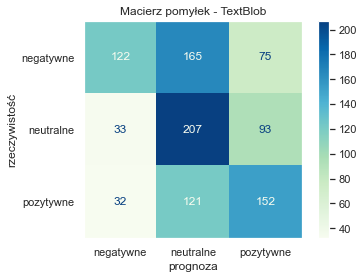

In [781]:
# textblob
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
print(classification_report(y_test, y_pred_textblob))

cm = confusion_matrix(y_test, y_pred_textblob, normalize=normalize)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=target_names)
disp = disp.plot(cmap='GnBu')
disp.ax_.set_title('Macierz pomyłek - TextBlob - lematyzacja')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       362
           1       0.84      0.66      0.74       333
           2       0.73      0.90      0.81       305

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



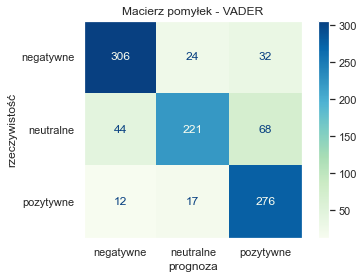

In [782]:
# vader
print(classification_report(y_test, y_pred_vader))

cm = confusion_matrix(y_test, y_pred_vader, normalize=normalize)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=target_names)
disp = disp.plot(cmap='GnBu')
disp.ax_.set_title('Macierz pomyłek - VADER')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)

#### Machine Learning algorithms

              precision    recall  f1-score   support

   negatywne       0.67      0.57      0.61       362
   neutralne       0.52      0.69      0.59       333
   pozytywne       0.61      0.50      0.55       305

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



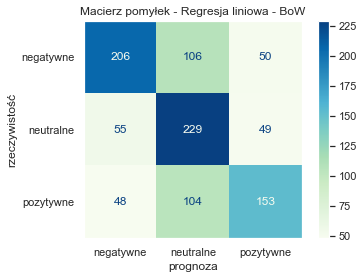

              precision    recall  f1-score   support

   negatywne       0.63      0.63      0.63       362
   neutralne       0.56      0.61      0.58       333
   pozytywne       0.62      0.56      0.59       305

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



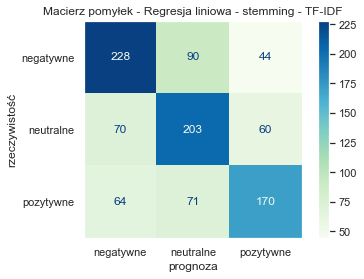

In [822]:
# logistic reggresion
print(classification_report(y_test, y_pred_lr, target_names=target_names))

disp = plot_confusion_matrix(lr_bow, X_test_bow, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - Regresja liniowa - BoW')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_lr_tfidf, target_names=target_names))

disp = plot_confusion_matrix(lr_tfidf, X_test_tfidf, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - Regresja liniowa - stemming - TF-IDF')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

   negatywne       0.55      0.68      0.61       362
   neutralne       0.54      0.38      0.44       333
   pozytywne       0.55      0.58      0.56       305

    accuracy                           0.55      1000
   macro avg       0.55      0.54      0.54      1000
weighted avg       0.55      0.55      0.54      1000



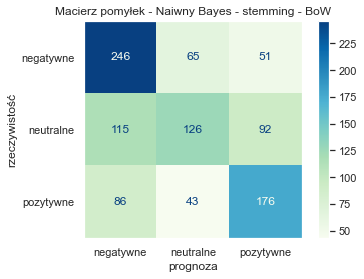

              precision    recall  f1-score   support

   negatywne       0.52      0.77      0.62       362
   neutralne       0.56      0.38      0.45       333
   pozytywne       0.60      0.46      0.52       305

    accuracy                           0.55      1000
   macro avg       0.56      0.54      0.53      1000
weighted avg       0.56      0.55      0.53      1000



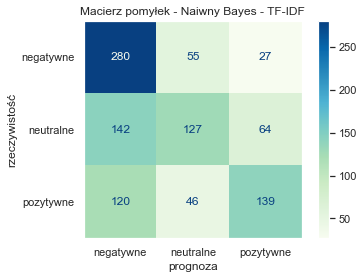

In [823]:
# naive bayes
print(classification_report(y_test, y_pred_nb, target_names=target_names))

disp = plot_confusion_matrix(nb_bow, X_test_bow, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - Naiwny Bayes - stemming - BoW')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_nb_tfidf, target_names=target_names))

disp = plot_confusion_matrix(nb_tfidf, X_test_tfidf, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - Naiwny Bayes - TF-IDF')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

   negatywne       0.64      0.59      0.61       362
   neutralne       0.51      0.65      0.57       333
   pozytywne       0.59      0.48      0.53       305

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000



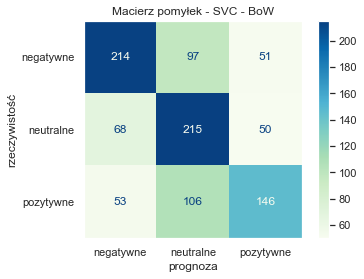

              precision    recall  f1-score   support

   negatywne       0.62      0.60      0.61       362
   neutralne       0.54      0.59      0.57       333
   pozytywne       0.61      0.57      0.59       305

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000



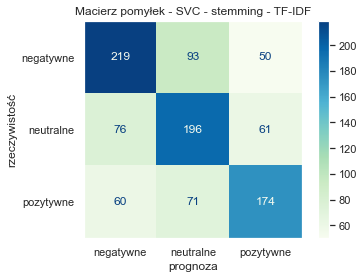

In [824]:
# svc
print(classification_report(y_test, y_pred_svc, target_names=target_names))

disp = plot_confusion_matrix(svc_bow, X_test_bow, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - SVC - BoW')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

print(classification_report(y_test, y_pred_svc_tfidf, target_names=target_names))

disp = plot_confusion_matrix(svc_tfidf, X_test_tfidf, y_test,
                                 display_labels=target_names,
                                 cmap='GnBu',
                                 normalize=normalize)    
disp.ax_.set_title('Macierz pomyłek - SVC - stemming - TF-IDF')
plt.xlabel('prognoza')
plt.ylabel('rzeczywistość')
plt.grid(False)
plt.show()

In [627]:
# roc_auc_score(y_test, y_pred_textblob, multi_class='ovr')

### ROC

Automatically created module for IPython interactive environment


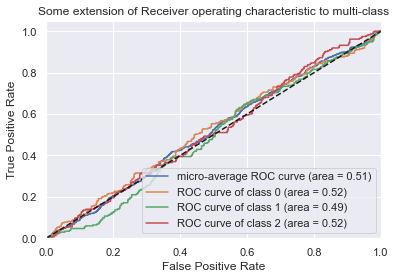

In [445]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
# from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# # Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# # shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train_tfidf, y_train).decision_function(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Wskaźnik ')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'lw' is not defined

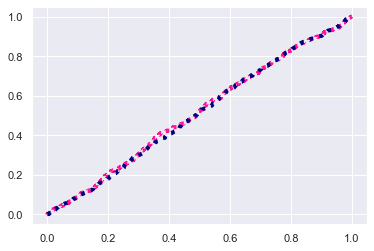

In [451]:
from itertools import cycle

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train_tfidf, y_train).decision_function(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [446]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

ValueError: X.shape[1] = 13900 should be equal to 2200, the number of features at training time

### Hyperparameter tuning

In [835]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

#### LR

In [836]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# n_iter_search = 20

pip_lr = make_pipeline(LogisticRegression(class_weight='balanced'))

lr_params = {'logisticregression__penalty' : ['l1', 'l2'],
             'logisticregression__C' : np.logspace(-4, 4, 20),
             'logisticregression__solver' : ['liblinear']}

gs_lr = GridSearchCV(pip_lr, param_grid=lr_params,
                            scoring='f1_weighted', cv=5, n_jobs=-1, refit=True)

gs_lr.fit(X_train_tfidf, y_train)

print("The best hyperparameters:")
print("-" * 25)

for hyperparam in gs_lr.best_params_.keys():

    print(hyperparam[hyperparam.find("__") + 2:],
          ": ", gs_lr.best_params_[hyperparam])

# Print CV
print('The best 5-folds CV f1_score is: {:.2f}%'.format(
    np.mean(gs_lr.best_score_) * 100))
    

#### NB


In [833]:
pip_nb = make_pipeline(MultinomialNB())

nb_params = {'multinomialnb__alpha': np.linspace(0.5, 1.5, 6),
             'multinomialnb__fit_prior': [True, False]}

gs_nb = GridSearchCV(pip_nb, param_grid=nb_params,
                            scoring='f1_weighted', cv=5, n_jobs=-1, refit=True)

gs_nb.fit(X_train_bow, y_train)

print("The best hyperparameters:")
print("-" * 25)

for hyperparam in gs_nb.best_params_.keys():

    print(hyperparam[hyperparam.find("__") + 2:],
          ": ", gs_nb.best_params_[hyperparam])

# Print CV
print('The best 10-folds CV f1_score is: {:.2f}%'.format(
    np.mean(gs_nb.best_score_) * 100))
    

The best hyperparameters:
-------------------------
alpha :  0.5
fit_prior :  True
The best 10-folds CV f1_score is: nan%


#### SVC

In [711]:
pip_svc = make_pipeline(SVC(class_weight='balanced',
                            probability=True))

svc_params = {'svc__kernel': ['rbf', 'poly'],
              'svc__gamma': [0.001, 0.01, 0.1, 1],
              'svc__C': [1, 10, 50, 100, 200, 300]}

gs_svc = GridSearchCV(pip_svc, param_grid=svc_params,
                            scoring='f1_weighted', cv=5, n_jobs=-1, refit=True)

gs_svc.fit(X_train_tfidf, y_train)

print("The best hyperparameters:")
print("-" * 25)

for hyperparam in gs_svc.best_params_.keys():

    print(hyperparam[hyperparam.find("__") + 2:],
          ": ", gs_svc.best_params_[hyperparam])

# Print CV
print('The best 10-folds CV f1_score is: {:.2f}%'.format(
    np.mean(gs_svc.best_score_) * 100))

The best hyperparameters:
-------------------------
kernel :  rbf
gamma :  0.001
C :  300
The best 10-folds CV accuracy is: 57.55%
